In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import math
#from sklearn.cross_validation import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lemma=WordNetLemmatizer()
stop=set(stopwords.words('english'))
import seaborn as sns
from mypipes import *
from matplotlib import pyplot as plt

In [2]:
cd_train=pd.read_csv(r'D:/Data/Consumer_Complaints_train.csv')
cd_test=pd.read_csv(r'D:/Data/Consumer_Complaints_test_share.csv')

In [3]:
cd_train['Consumer disputed?']=np.where(cd_train['Consumer disputed?']=="Yes",1,0)

In [4]:
cd_train['data']='train'
cd_test['data']='test'

In [5]:
cd_test['Consumer disputed?']=np.nan

In [6]:
cd_all=pd.concat([cd_train,cd_test],axis=0)

<AxesSubplot:xlabel='Product'>

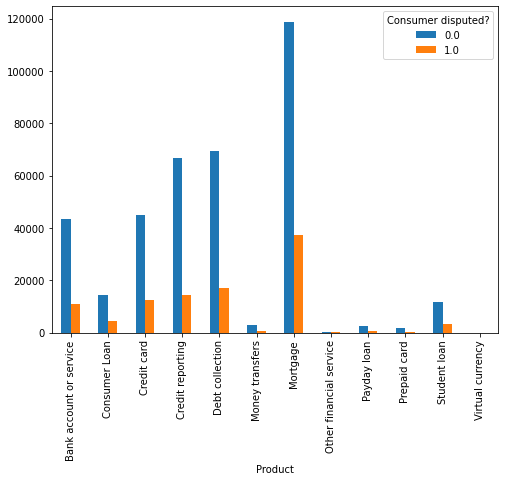

In [7]:
temp= pd.crosstab(cd_all['Product'], cd_all['Consumer disputed?'])

temp.plot(kind='bar',figsize=(8,6))

<AxesSubplot:xlabel='Company response to consumer'>

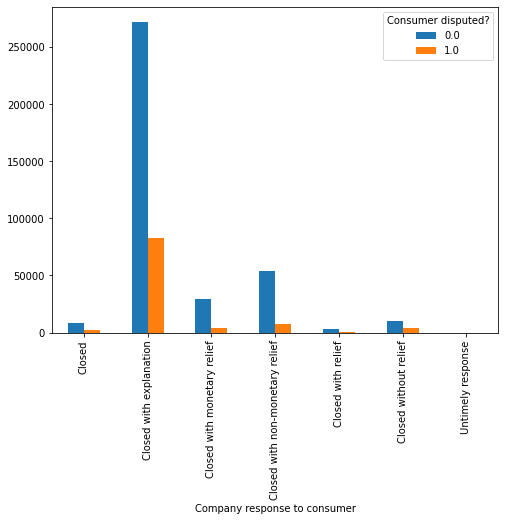

In [8]:
temp1= pd.crosstab(cd_all['Company response to consumer'], cd_all['Consumer disputed?'])
temp1.plot(kind='bar',figsize=(8,6)) ###Most cases are fall in closed with explaination

<AxesSubplot:xlabel='Product'>

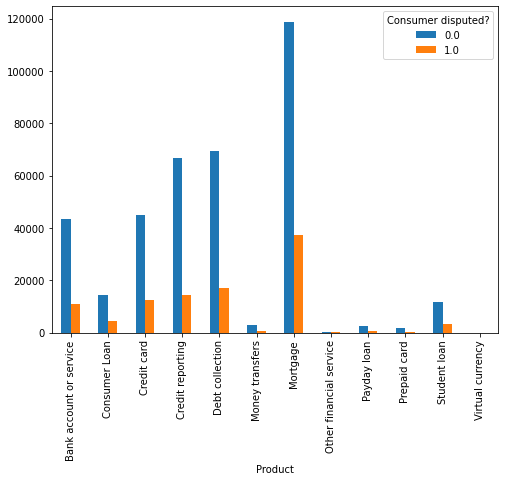

In [9]:
temp3= pd.crosstab(cd_all['Product'], cd_all['Consumer disputed?'])
temp3.plot(kind='bar',figsize=(8,6))

In [10]:
for col in ['Sub-product','Sub-issue',
            'Company public response','Tags','Consumer consent provided?']:
    varname=col.replace('-','_').replace('?','').replace(" ",'_')+'_isNan'
    cd_all[varname]=np.where(pd.isnull(cd_all[col]),1,0)
    cd_all.drop([col],1,inplace=True)

In [11]:
cd_all.columns

Index(['Date received', 'Product', 'Issue', 'Consumer complaint narrative',
       'Company', 'State', 'ZIP code', 'Submitted via', 'Date sent to company',
       'Company response to consumer', 'Timely response?',
       'Consumer disputed?', 'Complaint ID', 'data', 'Sub_product_isNan',
       'Sub_issue_isNan', 'Company_public_response_isNan', 'Tags_isNan',
       'Consumer_consent_provided_isNan'],
      dtype='object')

In [12]:
for col in ['Date received','Date sent to company']:
    cd_all[col]=pd.to_datetime(cd_all[col],infer_datetime_format=True)

In [13]:
import datetime
for col in ['Date received','Date sent to company']:
    cd_all['date_diff']=(cd_all["Date sent to company"].dt.year-cd_all['Date received'].dt.year)*12 +(cd_all["Date sent to company"].dt.month)-(cd_all['Date received'].dt.month)

In [14]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [15]:
cd_all = encode(cd_all, 'date_diff', 12)

In [16]:
for col in ['Date received','Date sent to company','date_diff']:
    cd_all.drop([col],inplace=True,axis=1)

In [17]:
cd_all.columns

Index(['Product', 'Issue', 'Consumer complaint narrative', 'Company', 'State',
       'ZIP code', 'Submitted via', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'data',
       'Sub_product_isNan', 'Sub_issue_isNan', 'Company_public_response_isNan',
       'Tags_isNan', 'Consumer_consent_provided_isNan', 'date_diff_sin',
       'date_diff_cos'],
      dtype='object')

In [18]:
cd_all.isnull().sum()/cd_all.shape[0]*100,

(Product                             0.000000
 Issue                               0.000000
 Consumer complaint narrative       84.340005
 Company                             0.000000
 State                               0.796620
 ZIP code                            0.798292
 Submitted via                       0.000167
 Company response to consumer        0.000000
 Timely response?                    0.000000
 Consumer disputed?                 20.000100
 Complaint ID                        0.000000
 data                                0.000000
 Sub_product_isNan                   0.000000
 Sub_issue_isNan                     0.000000
 Company_public_response_isNan       0.000000
 Tags_isNan                          0.000000
 Consumer_consent_provided_isNan     0.000000
 date_diff_sin                       0.000000
 date_diff_cos                       0.000000
 dtype: float64,)

In [19]:
for col in cd_all.select_dtypes(['object']).columns:
    print(col,':',cd_all[col].nunique())

Product : 12
Issue : 95
Consumer complaint narrative : 92118
Company : 3437
State : 62
ZIP code : 27342
Submitted via : 6
Company response to consumer : 7
Timely response? : 2
data : 2


In [20]:
# 'Sub-product','Sub-issue','Consumer complaint narrative',
            # 'Company public response','Tags','Consumer consent provided?'

In [21]:
cd_all['Submitted via'].fillna(cd_all['Submitted via'].mode()[0],inplace= True)

In [22]:
from pyzipcode import ZipCodeDatabase
zip1=ZipCodeDatabase()
for i in cd_all[pd.isnull(cd_all['State'])&pd.notnull(cd_all['ZIP code'])].index:
    try:
        cd_all['State'][i]=str(zip1[cd_all['ZIP code'][i]].state)
    except:
        continue

In [23]:
cd_all[pd.isnull(cd_all['State'])&pd.isnull(cd_all['ZIP code'])].shape

(4764, 19)

In [24]:
cd_all['State'].fillna('Not provided',inplace=True)
cd_all['ZIP code'].fillna('Not Provided',inplace=True)

In [25]:
cd_all.drop(['ZIP code','Company'],axis=1,inplace=True)

In [26]:
k=cd_train['Issue'].value_counts()
for val in k.axes[0][0:10]:
    varname='Issue_'+val.replace(',','_').replace(' ','_')
    cd_all[varname]=np.where(cd_all['Issue']==val,1,0)
del cd_all['Issue']

In [27]:
k=cd_train['State'].value_counts()
for val in k.axes[0][0:15]:
    varname='State_'+val.replace(',','_').replace(' ','_')
    cd_all[varname]=np.where(cd_all['State']==val,1,0)
del cd_all['State']


In [28]:
for col in ['Product','Submitted via','Company response to consumer','Timely response?']: 
    temp=pd.get_dummies(cd_all[col],prefix=col,drop_first=True)
    cd_all=pd.concat([temp,cd_all],1)
    cd_all.drop([col],1,inplace=True)

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
lemma=WordNetLemmatizer()
my_stop=set(stopwords.words('english')+list(punctuation))

In [30]:
cd_all["Consumer complaint narrative"]=np.where(pd.isnull(cd_all["Consumer complaint narrative"]),'NaN',cd_all['Consumer complaint narrative'])

In [31]:
def split_into_lemmas(message):
    words=word_tokenize(message)
    words_sans_stop=[]
    for word in words:
        if word in my_stop:continue
        words_sans_stop.append(word)
    return[lemma.lemmatize(word) for word in words_sans_stop]

In [32]:
tfidf=TfidfVectorizer(analyzer='word',stop_words='english',min_df=0.01,max_df=0.06,max_features=200)

In [30]:
tfidf.fit(cd_all["Consumer complaint narrative"])

TfidfVectorizer(max_df=0.06, max_features=200, min_df=0.01,
                stop_words='english')

In [31]:
tfidf_data=pd.DataFrame(data=tfidf.transform(cd_all["Consumer complaint narrative"]).toarray(),columns=tfidf.get_feature_names())

In [32]:
tfidf_data.head()

,00,2015,able,accounts,address,agency,ago,applied,asked,balance,...,tried,trying,used,want,way,went,work,xx,year,years
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.649655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
tfidf_data.shape

(598027, 141)

In [34]:
cd_all=pd.concat([cd_all,tfidf_data],axis=1)

In [35]:
cd_all.drop("Consumer complaint narrative",axis=1,inplace=True)

In [36]:
x_train=cd_all[cd_all['data']=='train']
del x_train['data']
x_test=cd_all[cd_all['data']=='test']
x_test.drop(['Consumer disputed?','data'],axis=1,inplace=True)

In [39]:
X_train=x_train.drop(['Complaint ID','Consumer disputed?'],1)
Y_train=x_train['Consumer disputed?']
X_test=x_test.drop('Complaint ID',1)

# Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
from sklearn.model_selection import GridSearchCV

In [52]:
model=LogisticRegression(fit_intercept=True)

In [53]:
params={
    'class_weight':['balanced','None'],#2
    'penalty':['l2','l1'],#
    'C':np.linspace(0.0001,1000,10)#10
    #combination=2*2*10=40
}

In [54]:
grid_search=GridSearchCV(model,param_grid=params,cv=5,scoring="roc_auc",n_jobs=-1)#n_jobs for how 

In [55]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.000000e-04, 1.111112e+02, 2.222223e+02, 3.333334e+02,
       4.444445e+02, 5.555556e+02, 6.666667e+02, 7.777778e+02,
       8.888889e+02, 1.000000e+03]),
                         'class_weight': ['balanced', 'None'],
                         'penalty': ['l2', 'l1']},
             scoring='roc_auc')

In [43]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import fbeta_score

# Xgboost

In [49]:
param_dist={
    "max_depth":[2,3,4,5,6],
    "learning_rate":[0.01,0.05,0.1,0.3,0.5],
    "min_child_weight":[4,5,6],
    "subsample":[i/10.0 for i in range(6,10)],
    "colsample_bytree":[i/10.0 for i in range(6,10)],
    "reg_alpha":[1e-5,1e-2,0.1,1,100],
    "gamma":[i/10.0 for i in range(0,5)],
    "n_estimators":[100,500,700,1000],
    "scale_pos_weight":[2,3,4,5,6,7,8,9]
}

In [49]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [50]:
clf=XGBClassifier(objective="binary:logistic")

In [50]:
X_train.drop('index',axis=1,inplace=True)
X_test.drop('index',axis=1,inplace=True)

In [52]:
n_iter=15
random_search=RandomizedSearchCV(clf,n_jobs=-1,verbose=3,n_iter=n_iter,scoring="roc_auc",cv=10,param_distributions=param_dist)

In [53]:
random_search.fit(X_train,Y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[06:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9

In [55]:
def report(results,n_top=3):
    for i in range(1, n_top+1):
        candidates=np.flatnonzero(results['rank_test_score']==i)
        for candidate in candidates:
            print("Model with rank:{0}".format(i))
            print("Mean validation score:{0:.8f}(std:{1:.3f})".format(results['mean_test_score'][candidate],results['std_test_score'][candidate]))
            print("Parameters:{0}".format(results['params'][candidate]))
            print("")

In [56]:
report(random_search.cv_results_)

Model with rank:1
Mean validation score:0.62439401(std:0.004)
Parameters:{'subsample': 0.6, 'scale_pos_weight': 8, 'reg_alpha': 100, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.6}

Model with rank:2
Mean validation score:0.62399051(std:0.004)
Parameters:{'subsample': 0.8, 'scale_pos_weight': 8, 'reg_alpha': 100, 'n_estimators': 700, 'min_child_weight': 6, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.9}

Model with rank:3
Mean validation score:0.62313144(std:0.003)
Parameters:{'subsample': 0.7, 'scale_pos_weight': 3, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 6, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}



In [ ]:
# Parameters:{'subsample': 0.6, 'scale_pos_weight': 8, 'reg_alpha': 100, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.6}

In [52]:
xgb_test = XGBClassifier(subsample=0.6,scale_pos_weight=8,reg_alpha=100,n_estimators=1000,min_child_weight=6,max_depth=4,learning_rate=0.1,gamma=0.4,colsample_bytree=0.6,n_jobs=-1)

In [53]:
xgb_test.fit(X_train,Y_train)

[11:20:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=100, reg_lambda=1, scale_pos_weight=8, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
prediction=xgb_test.predict(X_train)

In [58]:
pd.crosstab(Y_train, xgb_test.predict(X_train))

col_0,0.0,1.0
Consumer_disputed,,
0.0,50859,326131
1.0,4506,96925
